<a target="_blank" href="https://colab.research.google.com/github/elliottabe/mujoco_workshop2024/blob/main/Introduction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install mujoco

In [1]:

# Set up GPU rendering.
# from google.colab import files
import platform
import distutils.util
import os
import subprocess
if platform.system() != 'Darwin':
  # Configure MuJoCo to use the EGL rendering backend (requires GPU)
  print('Setting environment variable to use GPU rendering:')
  %env MUJOCO_GL=egl

  # Check if installation was succesful.
  try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
  except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else: 
  import mujoco
print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
# clear_output()


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:


libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: NEEDS EXTENSION: falling back to kms_swrast


Installation successful.
Installing mediapy:


# Outline of Workshop

- Introduction
    - Basics of MuJoco models
    - Simulations and Rendering
    - Measuring values
    - Contacts
    - Actuators
    - Sensors
    - Tendons
- Biomechanical Bodies
    - Flybody Model
        - Breakdown
        - Kinematic Replay
- Reinforcement Learning in MuJoCo
    - MJX/Brax
    - Quadruped Envronment

# Introduction

MuJoCo stands for **Mu**lti-**Jo**int dynamics with **Co**ntact. It is a general purpose physics engine that aims to facilitate research and development in robotics, biomechanics, graphics and animation, machine learning, and other areas that demand fast and accurate simulation of articulated structures interacting with their environment. 

Key Features of MuJoCo: 
 - Generalized coordinates combined with modern contact dynamics
 - Soft, convex and analytically-invertible contact dynamics
 - Tendon geometry
 - General actuation model
 - Reconfigurable computation pipeline
 - Model compilation
 - Separation of model and data
 - Interactive simulation and visualization
 - Powerful yet intuitive modeling language
 - Automated generation of composite flexible objects

Workflow Overview
 - The workflow MuJoCo typically starts with a user defined XML file that specifies the model and environment at compilation time. 
 - MuJoCo is written in C/C++ but has python and unity binding for additional devleopment
 - There are two main stuctures in MujoCo: 
   - mjModel: specifies the kinematic tree for calculating collisions and forces. Parts of the model independent of time. 
   - mjData: specifies simulated state of the model and enviornment. Parts of the model that are time dependent.

<img align="left" src="Images/workflow.png" alt="drawing" width="300"/>
<!-- &nbsp;  -->
<img src="Images/kinematic_tree.png" alt="drawing" height="300"/>
<img src="Images/simulated_state.png" alt="drawing" height="300"/>

# Basics

There are three main ways to interact with designing MuJoCo models:
 - Building XML from stings/loading XML files with native MuJoCo.
    - Pros: 
        - Works without any additional packages.
        - Will be up to date with any MuJoCo changes.
        - Well documented
    - Cons:
        - Only basic control of models and data, many utility functions not fully supported.
 - MJCF through dm_control
    - Pros: 
        - Lots of utility functions to understand and manipulate models.
        - Built for Reinforcement Learning (RL) so environments and rewards are easily constructed.
    - Cons:
        - Will be slower to get updated features in MuJoCo since development is independent of MuJoCo.
        - Functions are not well documented
 - MuJoCo MjSpec (newly developed)
    - Pros:
        - Will be continually updated by the people who maintain MuJoCo.
        - Well documented.
    - Cons:
        - Brand new and will take some time to flush out full development.

For this workshop we will focus on ***XML in native MuJoCo*** and ***MJCF in dm_control***.

The beginning of this Workshop is taken from MuJoCo's Tutorial notebook with modifications to explain features more in depth where needed. 

## XML String/Files with native MuJoCo

To start with we will begin by defining a simple xml string to generate a box and sphere geoms.

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
  - We define two geoms in the world named `red_box` and `green_sphere`.
  - **Question:** The `red_box` has no position, the `green_sphere` has no type, why is that?
    - **Answer:** MJCF attributes have *default values*. The default position is `0 0 0`, the default geom type is `sphere`. The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

The `from_xml_string()` method invokes the model compiler, which creates a binary `mjModel` instance.

## mjModel

MuJoCo's `mjModel`, contains the *model description*, i.e., all quantities which *do not change over time*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [ ]:
model.ngeom

In [ ]:
model.geom_rgba

## Named access

The MuJoCo Python bindings provide convenient [accessors](https://mujoco.readthedocs.io/en/latest/python.html#named-access) using names. Calling the `model.geom()` accessor without a name string generates a convenient error that tells us what the valid names are.

In [ ]:
try:
  model.geom()
except KeyError as e:
  print(e)

Calling the named accessor without specifying a property will tell us what all the valid properties are:

In [ ]:
model.geom('green_sphere')

Let's read the `green_sphere`'s rgba values:

In [ ]:
model.geom('green_sphere').rgba

This functionality is a convenience shortcut for MuJoCo's [`mj_name2id`](https://mujoco.readthedocs.io/en/latest/APIreference.html?highlight=mj_name2id#mj-name2id) function:

In [ ]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

Similarly, the read-only `id` and `name` properties can be used to convert from id to name and back:

In [ ]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

Note that the 0th body is always the `world`. It cannot be renamed.

The `id` and `name` attributes are useful in Python comprehensions:

In [ ]:
[model.geom(i).name for i in range(model.ngeom)]

## `mjData`
`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

In [ ]:
data = mujoco.MjData(model)

`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [ ]:
print(data.geom_xpos)

Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated (see [below](#scrollTo=QY1gpms1HXeN)). In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [ ]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

# Basic rendering, simulation, and animation

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

We'll also reload our model to make the colab's sections independent.

""

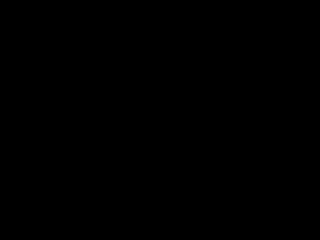

In [2]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  media.show_image(renderer.render())

Why the black pixels?

**Answer:** For the same reason as above, we first need to propagate the values in `mjData`. This time we'll call [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference/APIfunctions.html#mj-forward), which invokes the entire pipeline up to the computation of accelerations i.e., it computes $\dot x = f(x)$, where $x$ is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call `mj_forward` since then we know we are not missing anything.

We also need to update the `mjvScene` which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

In [ ]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

This worked, but this image is a bit dark. Let's add a light and re-render.

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1" diffuse="0.3 0.3 0.3"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

## Simulation

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$.

Note that in the code block below we are *not* rendering after each call to `mj_step`. This is because the default timestep is 2ms, and we want a 60fps video, not 500fps.

We first need to define [degrees of freedom](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics)) (DoFs). The things that move (and which have inertia) are called *bodies*. We add DoFs by adding *joints* to bodies, specifying how they can move with respect to their parents. Let's make a new body that contains our geoms, add a hinge joint and re-render, while visualizing the joint axis using the visualization option object `MjvOption`.

There are four [joint](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-joint) types: 
- **Free**: 6 DoFs (3 translational and 3 rotational)
- **Ball**: 3 DoFs (3 rotational)
- **Slide**: 1 DoF (1 translational)
- **Hinge**: 1 DoF (1 rotational)

In [73]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

Note that we rotated the `box_and_sphere` body by 30° around the Z (vertical) axis, with the directive `euler="0 0 -30"`. This was made to emphasize that the poses of elements in the [kinematic tree](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FKinematic_chain) are always with respect to their *parent body*, so our two geoms were also rotated by this transformation.

Physics options live in `mjModel.opt`, for example the timestep:

The positions and orientations of all elements defined in the kinematic tree are expressed in local coordinates, relative to the parent body for bodies, and relative to the body that contains the element for geoms, joints, sites, cameras and lights.

In [84]:
model.opt.timestep

0.002

Let's flip gravity and re-render:

In [ ]:
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=60)

We could also have done this in XML using the top-level `<option>` element:
```xml
<mujoco>
  <option gravity="0 0 10"/>
  ...
</mujoco>
```

### Understanding Degrees of Freedom

In the real world, all rigid objects have 6 degrees-of-freedom: 3 translations and 3 rotations. Real-world joints act as constraints, removing relative degrees-of-freedom from bodies connected by joints. Some physics simulation software use this representation which is known as the "Cartesian" or "subtractive" representation, but it is inefficient. MuJoCo uses a representation known as the "Lagrangian", "generalized" or "additive" representation, whereby objects have no degrees of freedom unless explicitly added using joints.

Our model, which has a single hinge joint, has one degree of freedom, and the entire state is defined by this joint's angle and angular velocity. These are the system's generalized position and velocity.

In [ ]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

MuJoCo's use of generalized coordinates is the reason that calling a function (e.g. [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward)) is required before rendering or reading the global poses of objects – Cartesian positions are *derived* from the generalized positions and need to be explicitly computed.

# Example: Analysis of contact forces

A free body is a body with a [free joint](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint) having 6 DoFs, i.e., 3 translations and 3 rotations. We will give our `box_and_sphere` body a free joint and watch it fall.

""

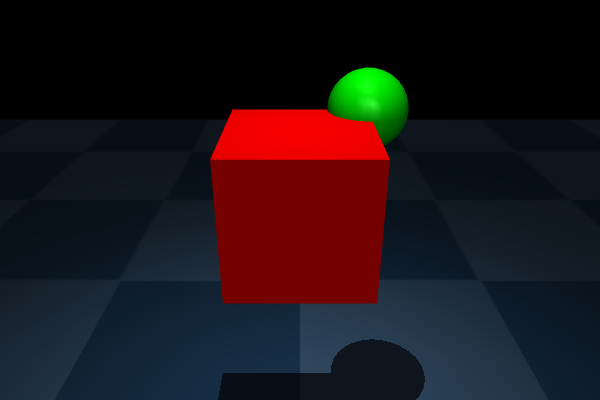

In [76]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
data = mujoco.MjData(model)
height = 400
width = 600

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

Note several new features of this model definition:
1. A 6-DoF free joint is added with the `<freejoint/>` clause.
2. We define the floor's grid material inside the `<asset/>` clause and reference it in the `"floor"` geom.
3. We define a `<camera>` in our model, and then render from it using the `camera` argument to `update_scene()`.
Let us examine the state:


Let render this body rolling on the floor, in slow-motion, while visualizing contact points and forces:

In [77]:
n_frames = 200
height = 240
width = 320
frames = []

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/120.0: #1/4x real time
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "track", options)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)

In [78]:
print('positions', data.qpos)
print('velocities', data.qvel)

positions [-0.091  0.05  -0.4    0.625 -0.331 -0.625 -0.331]
velocities [-0.  0.  0. -0. -0. -0.]


The velocities are easy to interpret, 6 zeros, one for each DoF. What about the length 7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. 3D orientations are represented with **4** numbers while angular velocities are **3** numbers. For more information see the Wikipedia article on [quaternions and spatial rotation](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).

Additional explanations on quaternions: 
 - [Great Visualiztions by 3Blue1Brown/Ben Eater](https://eater.net/quaternions)
 - [Quick Video](https://www.youtube.com/watch?v=zjMuIxRvygQ)
 - [Long Video](https://www.3blue1brown.com/lessons/quaternions)


### Measuring values from `mjData`
As mentioned above, the `mjData` structure contains the dynamic variables and intermediate results produced by the simulation which are *expected to change* on each timestep. 

Let's rerun the above simulation (with a different random initial condition) and
plot some values related to the contacts

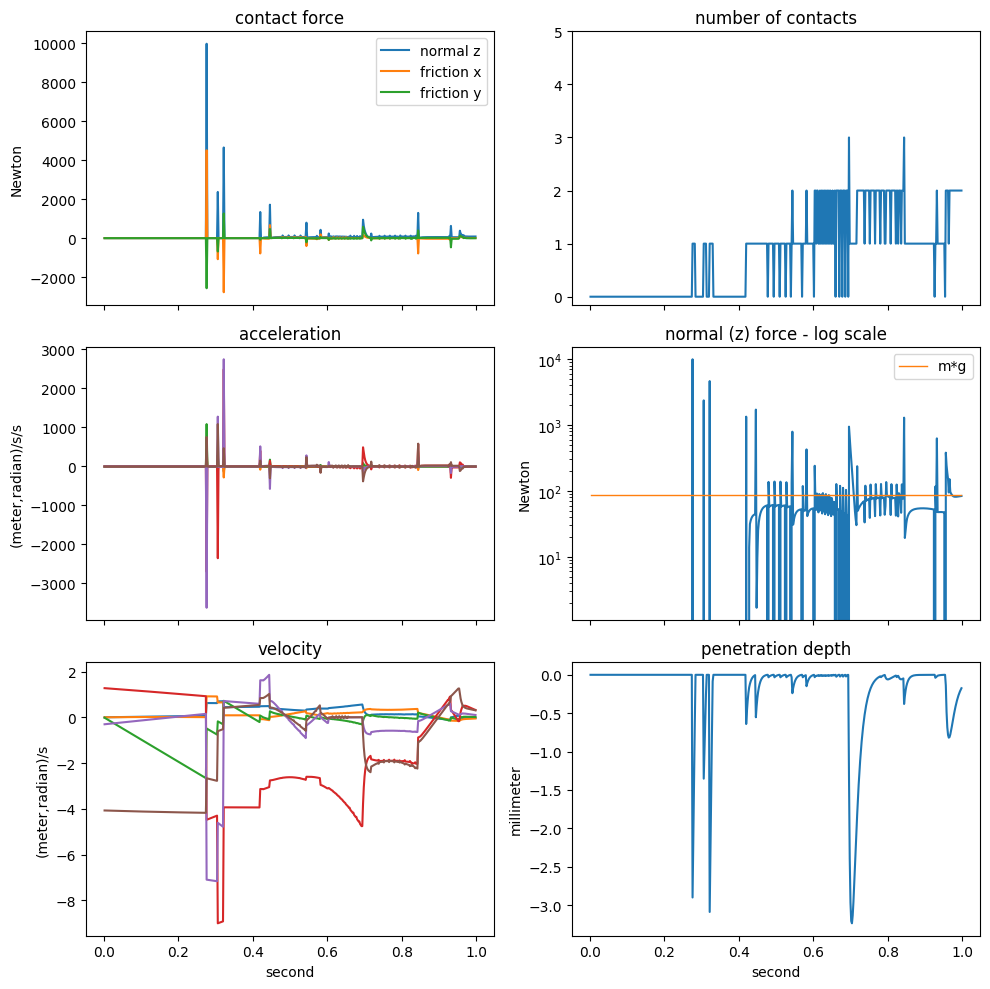

In [83]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()

# Example: A chaotic pendulum

Below is a model of a chaotic pendulum, similar to [this one](https://www.exploratorium.edu/exhibits/chaotic-pendulum) in the San Francisco Exploratorium.

In [ ]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

## Timing
Let's see a video of it in action while we time the components:

In [ ]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

Note that rendering is **much** slower than the simulated physics.

## Friction

Let's see the effect of changing friction values

In [ ]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_resetData(model, data)
  for i in range(n_frames):
    while data.time < i/30.0:
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "y")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)

# Actuators and sensors

## Actuators

MuJoCo provides a flexible actuator model. All actuators are single-input-single-output (SISO). 
- The input to actuator $i$ is a scalar control $u_i$​ specified by the user. 
- The output is a scalar force $p_i$​ which is mapped to joint coordinates by a vector of moment arms determined by the transmission. 
- An actuator can also have activation state $w_i$​ with its own dynamics. 
- The control inputs for all actuators are stored in `mjData.ctrl`, the force outputs are stored in `mjData.actuator_force`, and the activation states (if any) are stored in `mjData.act`. 
- More info on [computational model](https://mujoco.readthedocs.io/en/stable/computation/index.html#actuation-model).

There are several different options for actuators model. There is one overall model called a `general` actuator and shortcuts: 
- [general](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-general): Providing full access to all actuator components and allowing the user to specify them independently.
- [motor](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-motor): Shortcut for direct-drive actuator.
- [position](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-position): Shortcut for a position servo with an optional first-order filter.
- [velocity](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-velocity):Shortcut for a velocity servo. 
- [intvelocity](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-intvelocity): Shortcut for an integrated-velocity servo
- [damper](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-damper): Creates a active damper which produces a force proportional to both velocity and control: `F = - kv * velocity * control`, where `kv` must be nonnegative.
- [cylinder](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-cylinder): Shortcut for element that is suitable for modeling pneumatic or hydraulic cylinders. 
- [muscle](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-muscle): Creates an element used to model a muscle actuator. 
- [adhesion](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-adhesion): Defines an active adhesion actuator which injects forces at contacts in the normal direction. 

## Sensors

MuJoCo contains many sensors that can be found [here](https://mujoco.readthedocs.io/en/stable/XMLreference.html#sensor). Some common ones are: 
- touch
- accelerometer
- velocimeter
- gyro
- force
- torques
- magnetometer
- jointpos
- jointvel
- actuatorpos
- actuatorvel
- framepos
- framequant
- framelinvel

These sensors are used to collect data during simulations. 
The outputs of all sensors are concatenated in the field mjData.sensordata which has size mjModel.nsensordata. This data is not used in any internal computations.

## Simple example of actuators and sensors

In [102]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1" diffuse="1 1 1" />
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
      <site name="IMU"/>
    </body>

  </worldbody>
  
  <!-- Motor Actuator controlling the hinge joint -->
  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <!-- Accelerometer Sensor -->
    <accelerometer name="Accelerometer" site="IMU"/>
    <!-- Motor Actuator controlling the hinge joint -->
    <framepos name="pos" objtype="geom" objname="bat"/>
  </sensor>
</mujoco>
"""

n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
dt = model.opt.timestep

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20 # Adding constant force to bat

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      times.append(data.time)
      sensordata.append(data.sensordata.copy())
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)

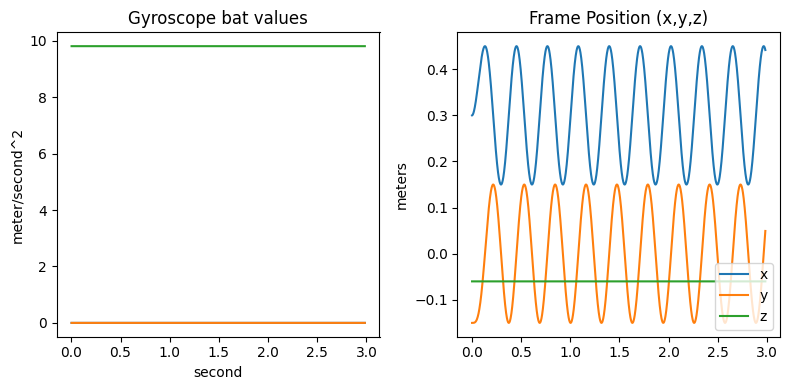

In [ ]:
# Plotting sensors
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs = axs.flatten()
times = np.asarray(times)
sensordata = np.asarray(sensordata)

# plotting Accelerometer data
ax = axs[0]
ax.plot(times,sensordata[:,:3], )
# finalize plot
ax.set_title('Accelerometer bat values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')

# Plotting global position of the bat
ax = axs[1]
ax.plot(times,sensordata[:,3:7])
ax.set_title('Frame Position (x,y,z)')
ax.set_ylabel('meters')
ax.legend(['x','y','z'], frameon=True, loc='lower right');
plt.tight_layout()

# Tendons

[Tendons](https://mujoco.readthedocs.io/en/stable/XMLreference.html#tendon) can be used to impose length limits, simulate spring, damping and dry friction forces, as well as attach actuators to them.
- Spatial Tendons: a minimum-length path passing through specified via-points and wrapping around specified obstacle geoms. 
- Fixed Tendons: creates an abstract tendon whose length is defined as a linear combination of joint positions.

In [72]:
Tendon_MJCF = """
<mujoco model="tendon">
  <default>
    <joint axis="0 1 0" range="0 60" limited="true"/>
    <geom type="capsule" size=".01" rgba=".9 .7 .1 1"/>
    <site rgba=".9 .9 .9 1"/>
    <default class="visual_cylinder">
      <geom type="cylinder" fromto="0 .015 0  0 -.015 0" size=".02" rgba=".3 .9 .3 .4"/>
    </default>
  </default>

  <worldbody>
    <light pos="0 0 1"/>
    <camera name="fixed" pos=".1 -.5 .5" xyaxes="1 0 0 0 1 2"/>
    <body name="weight" pos="-.03 0 .175">
      <joint axis="0 0 1" pos="0 0 .025" type="slide"/>
      <geom type="cylinder" size=".03 .025" density="5000" rgba=".2 .2 .5 1"/>
      <site name="s1" pos="0 0 .025"/>
    </body>

    <site name="s2" pos="-.03 0 .33"/>

    <body pos="0 0 .3">
      <joint/>
      <geom name="g1" class="visual_cylinder"/>
      <geom fromto="0 0 0  .1 0 0"/>
      <site name="s3" pos=".02 0 .03"/>

      <body pos=".1 0 0">
        <joint/>
        <geom name="g2" class="visual_cylinder"/>
        <geom fromto="0 0 0  .1 0 0"/>
        <site name="s4" pos=".03 0 .01"/>
        <site name="s5" pos=".05 0 .02"/>
        <site name="side2" pos="0 0 .03"/>

        <body pos=".1 0 0">
          <joint/>
          <geom name="g3" class="visual_cylinder"/>
          <geom fromto="0 0 0  .1 0 0"/>
          <site name="s6" pos=".03 0 .01"/>
          <site name="side3" pos="0 0 .03"/>
        </body>
      </body>
    </body>
  </worldbody>

  <tendon>
    <spatial range="0 .33" limited="true" width=".002" rgba=".95 .3 .3 1">
      <site site="s1"/>
      <site site="s2"/>
      <geom geom="g1"/>
      <site site="s3"/>

      <pulley divisor="2"/>
      <site site="s3"/>
      <geom geom="g2" sidesite="side2"/>
      <site site="s4"/>

      <pulley divisor="2"/>
      <site site="s3"/>
      <geom geom="g2" sidesite="side2"/>
      <site site="s5"/>
      <geom geom="g3" sidesite="side3"/>
      <site site="s6"/>
    </spatial>
  </tendon>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(Tendon_MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

n_frames = 120
frames = []

# load
model = mujoco.MjModel.from_xml_string(Tendon_MJCF)
data = mujoco.MjData(model)
dt = model.opt.timestep

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_resetData(model, data)
  for i in range(n_frames):
    while data.time < i/30.0:
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)


## All Together 

""

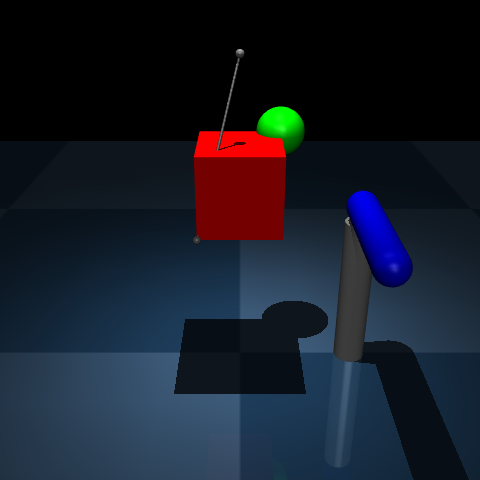

In [107]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1" diffuse="1 1 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

actuated bat and passive "piñata":

In [108]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      times.append(data.time)
      sensordata.append(data.sensor('accelerometer').data.copy())
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)

Let's plot the values measured by our accelerometer sensor:

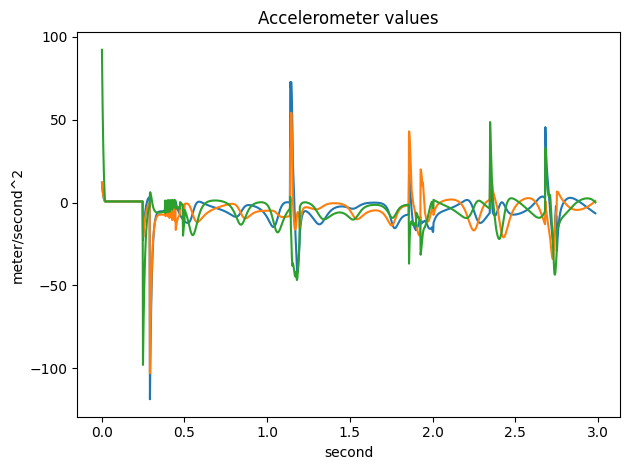

In [109]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced Rendering

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [ ]:
#@title Enable transparency and frame visualization {vertical-output: true}

scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, scene_option=scene_option)
  frame = renderer.render()
  media.show_image(frame)

In [ ]:
#@title Depth rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  # update renderer to render depth
  renderer.enable_depth_rendering()

  # reset the scene
  renderer.update_scene(data)

  # depth is a float array, in meters.
  depth = renderer.render()

  # Shift nearest values to the origin.
  depth -= depth.min()
  # Scale by 2 mean distances of near rays.
  depth /= 2*depth[depth <= 1].mean()
  # Scale to [0, 255]
  pixels = 255*np.clip(depth, 0, 1)

  media.show_image(pixels.astype(np.uint8))

In [ ]:
#@title Segmentation rendering {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_depth_rendering()

  # update renderer to render segmentation
  renderer.enable_segmentation_rendering()

  # reset the scene
  renderer.update_scene(data)

  seg = renderer.render()

  # Display the contents of the first channel, which contains object
  # IDs. The second channel, seg[:, :, 1], contains object types.
  geom_ids = seg[:, :, 0]
  # Infinity is mapped to -1
  geom_ids = geom_ids.astype(np.float64) + 1
  # Scale to [0, 1]
  geom_ids = geom_ids / geom_ids.max()
  pixels = 255*geom_ids
  media.show_image(pixels.astype(np.uint8))

In [ ]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

In [ ]:
#@title Project from world to camera coordinates {vertical-output: true}

with mujoco.Renderer(model) as renderer:
  renderer.disable_segmentation_rendering()
  # reset the scene
  renderer.update_scene(data)

  # Get the world coordinates of the box corners
  box_pos = data.geom_xpos[model.geom('red_box').id]
  box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
  box_size = model.geom_size[model.geom('red_box').id]
  offsets = np.array([-1, 1]) * box_size[:, None]
  xyz_local = np.stack(list(itertools.product(*offsets))).T
  xyz_global = box_pos[:, None] + box_mat @ xyz_local

  # Camera matrices multiply homogenous [x, y, z, 1] vectors.
  corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
  corners_homogeneous[:3, :] = xyz_global

  # Get the camera matrix.
  m = compute_camera_matrix(renderer, data)

  # Project world coordinates into pixel space. See:
  # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
  xs, ys, s = m @ corners_homogeneous
  # x and y are in the pixel coordinate system.
  x = xs / s
  y = ys / s

  # Render the camera view and overlay the projected corner coordinates.
  pixels = renderer.render()
  fig, ax = plt.subplots(1, 1)
  ax.imshow(pixels)
  ax.plot(x, y, '+', c='w')
  ax.set_axis_off()

In [ ]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/16  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    # append data to the traces
    positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
    times.append(data.time)
    speeds.append(get_geom_speed(model, data, "green_sphere"))
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      modify_scene(renderer.scene)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)